# **This Notebook shows precedures I took to Finetune Llama3 (8B) for extracting medical Entities**

In [ ]:
!pip install torch transformers datasets trl peft accelerate bitsandbytes

In [ ]:
from huggingface_hub import login

 hf-token = user_secrets.get_secret("hf-token")

login(token= hf-token)


In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging
from peft import LoraConfig, PeftModel,prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset
from trl import SFTTrainer
import torch

checkpoint = "meta-llama/Meta-Llama-3.1-8B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [2]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 1050939392
all model parameters: 4540600320
percentage of trainable model parameters: 23.15%




---



In [3]:
tokenizer.pad_token = tokenizer.eos_token

In [5]:
EOS_TOKEN = tokenizer.eos_token

In [7]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

              ### Instruction:
              {}

              ### Input:
              {}

              ### Response:
              {}"""



def formatting_prompts_func(examples):

    instructions = []
    inputs = []
    outputs = []

    for dialogue, section_text in zip(examples["dialogue"], examples["section_text"]):
        # Customize the instruction based on your specific fine-tuning goals
        instructions.append("""
              Extract the symptoms, diagnosis, medical history, and action plan from the following medical conversation.
              Return the results as a JSON object with the following keys:
              {
                "Symptoms": [list of symptoms],
                "Diagnosis": [list of diagnoses],
                "Medical history": [list of medical history items],
                "Action plan": [list of action plan items]
              }
              """)

        inputs.append(dialogue)
        outputs.append(section_text)

    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}


In [8]:
from datasets import load_dataset

dataset = load_dataset("har1/MTS_Dialogue-Clinical_Note", split = "train")

dataset

Generating train split:   0%|          | 0/1301 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'section_header', 'section_text', 'dialogue'],
    num_rows: 1301
})

In [9]:
dataset = dataset.remove_columns(['ID', 'section_header'])

dataset

Dataset({
    features: ['section_text', 'dialogue'],
    num_rows: 1301
})

In [10]:
dataset = dataset.map(formatting_prompts_func, batched = True)

dataset

Map:   0%|          | 0/1301 [00:00<?, ? examples/s]

Dataset({
    features: ['section_text', 'dialogue', 'text'],
    num_rows: 1301
})

In [11]:
i=0

print(f"Sample {i+1} Dialogue:\n{dataset[i]['dialogue']}\n\n")
print(f"Sample {i+1} Clinical Note:\n{dataset[i]['section_text']}\n\n")
print(f"Sample {i}+1 Text:\n{dataset[i]['text']}")
print("------------\n")


Sample 1 Dialogue:
Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.


Sample 1 Clinical Note:
Symptoms: no fever, no chills, no cough, no congestion, no nausea, no vomiting, no chest pain, no chest pressure.
Diagnosis: hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones
History of Patient: 76-year-old white female, prese

In [12]:
train_dataset, validation_dataset = dataset.train_test_split(test_size=0.1).values()

In [13]:
train_dataset

Dataset({
    features: ['section_text', 'dialogue', 'text'],
    num_rows: 1170
})

In [14]:
validation_dataset

Dataset({
    features: ['section_text', 'dialogue', 'text'],
    num_rows: 131
})

In [16]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 41943040
all model parameters: 4582543360
percentage of trainable model parameters: 0.92%


In [34]:
index = 0

def predict_Llama(model, tokenizer, text):
    # Tokenize and generate the output
    inputs = tokenizer([
        prompt.format(
            """Extract the name, age, gender, symptoms, diagnosis, medical history, and action plan from the following medical conversation.
            Provide the result in the following JSON format:
            { 'Name': [...], 'Age': [...], 'Gender': [...], 'Symptoms': [...], 'Diagnosis': [...], 'Medical history': [...], 'Action plan': [...] }.""",
            text,
            ""  # Leave this blank for generation
        )
    ],
                       return_tensors="pt",
                       truncation=True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)
    extracted_entities = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract and parse the response
    response = extracted_entities.split("### Response:", 1)[-1].strip()
    response_dict = {k.strip(): v.strip() for k, v in (line.split(': ', 1) for line in response.splitlines() if ': ' in line)}

    return response_dict


text = dataset["dialogue"][index]
response_dict = predict_Llama(model, tokenizer, text)
print(response_dict)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'Symptoms': 'N/A.', 'Diagnosis': 'Hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones.', 'History of Patient': 'N/A.', 'Plan of Action': 'N/A.', 'Patient': 'N/A.', 'Doctor': 'N/A.'}


In [35]:
dataset["section_text"][index]

'Symptoms: no fever, no chills, no cough, no congestion, no nausea, no vomiting, no chest pain, no chest pressure.\nDiagnosis: hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones\nHistory of Patient: 76-year-old white female, presents to the clinic today originally for hypertension and a med check, followed by Dr. Kumar, issues stable\nPlan of Action: N/A'

In [ ]:
import datasets

datasets.config.NUM_PROC = 1 

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=100,  
        # num_train_epochs=4,
        learning_rate=2e-4,
        fp16= not torch.cuda.is_bf16_supported(),
        bf16= torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        eval_strategy="steps",
        eval_steps=10,
        save_steps=10,
        save_total_limit=2
    )

In [19]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,  
    eval_dataset=validation_dataset, 
    dataset_text_field="text",
    max_seq_length=512,
    dataset_num_proc=2,
    packing=False,
    args=training_args
)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_num_proc. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:297: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you 

In [20]:
trainer_stats = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
10,0.779700,1.004150
20,0.944300,0.936992
30,0.608800,0.906880
40,0.714700,0.897488
50,0.850100,0.889313
60,0.890600,0.887190
70,0.518500,0.880692
80,0.680300,0.875958
90,0.960400,0.874223
100,0.710000,0.872699


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [53]:
import wandb

wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
wandb.finish()
model.config.use_cache = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


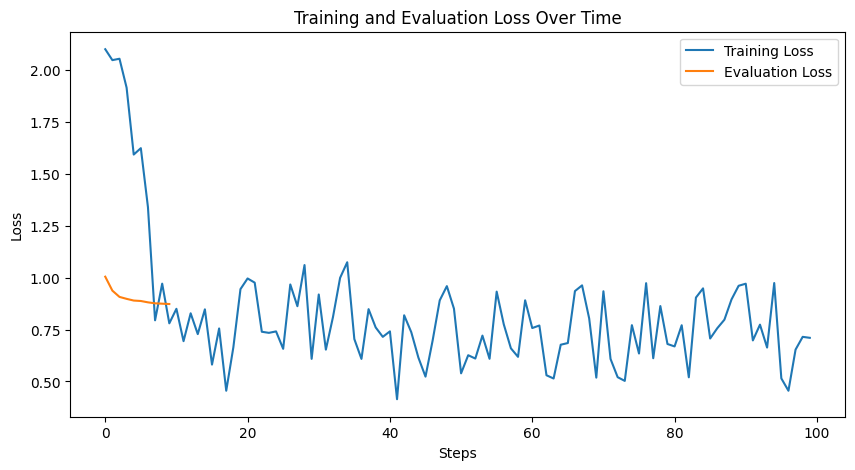

In [25]:
from matplotlib import pyplot as plt

loss_logger = trainer.state.log_history

train_losses = [log['loss'] for log in loss_logger if 'loss' in log]
eval_losses = [log['eval_loss'] for log in loss_logger if 'eval_loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss Over Time')
plt.show()


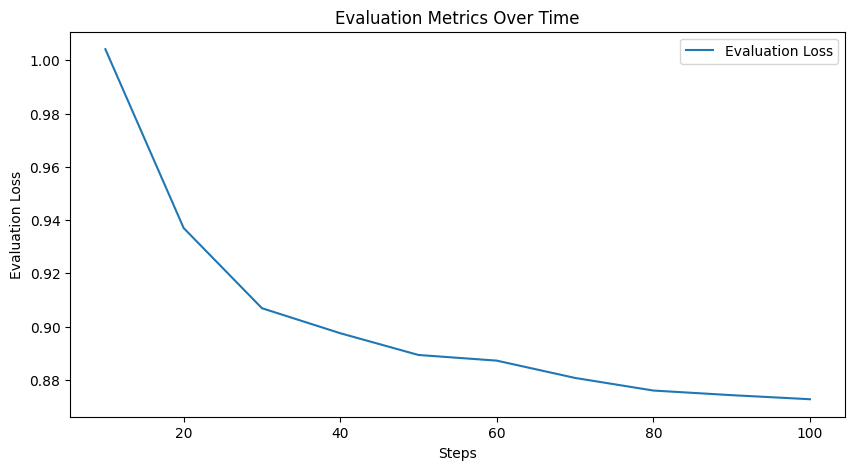

In [29]:
eval_metrics = [log for log in loss_logger if 'eval_loss' in log]

eval_steps = [log['step'] for log in eval_metrics]
eval_losses = [log['eval_loss'] for log in eval_metrics]

plt.figure(figsize=(10, 5))
plt.plot(eval_steps, eval_losses, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Evaluation Loss')
plt.legend()
plt.title('Evaluation Metrics Over Time')
plt.show()

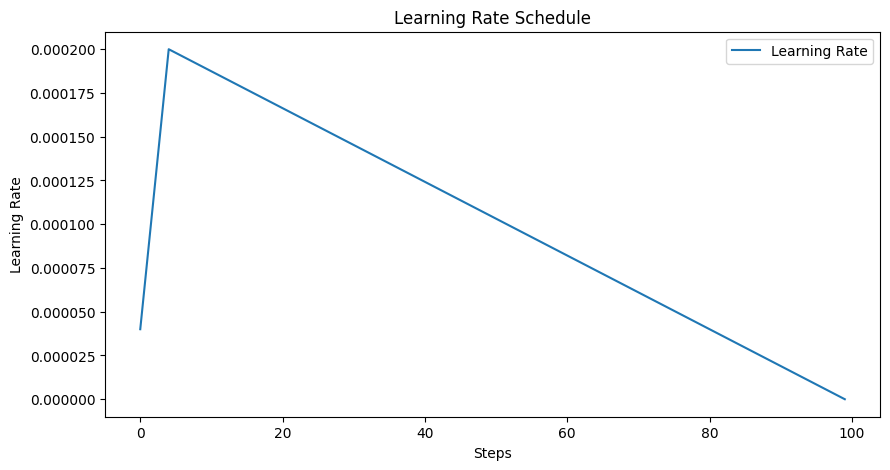

In [26]:
lr_schedule = [log['learning_rate'] for log in loss_logger if 'learning_rate' in log]

plt.figure(figsize=(10, 5))
plt.plot(lr_schedule, label='Learning Rate')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule')
plt.show()


In [58]:
text = dataset["dialogue"][index]
response_dict = predict_Llama(model, tokenizer, text)
print(response_dict)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'Symptoms': 'N/A', 'Diagnosis': 'Hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones', 'History of Patient': 'N/A', 'Plan of Action': 'N/A', 'Gender': 'Female', 'Age': '76', 'Race': 'Caucasian'}


In [59]:
dataset["section_text"][index]

'Symptoms: no fever, no chills, no cough, no congestion, no nausea, no vomiting, no chest pain, no chest pressure.\nDiagnosis: hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones\nHistory of Patient: 76-year-old white female, presents to the clinic today originally for hypertension and a med check, followed by Dr. Kumar, issues stable\nPlan of Action: N/A'

In [60]:
from huggingface_hub import login

login(token= hf-token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [64]:
from peft import PeftModel

finetuned_model = "/kaggle/working/Llama3_finetune_for_medical_entity_extraction"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

base_model_reload = AutoModelForCausalLM.from_pretrained(
    checkpoint,
    return_dict=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [65]:
# Merge adapter with base model
model = PeftModel.from_pretrained(base_model_reload, finetuned_model)

model = model.merge_and_unload()

In [66]:
text = dataset["dialogue"][index]
response_dict = predict_Llama(model, tokenizer, text)
print(response_dict)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{"{ 'Name'": "'Patient', 'Age': '76', 'Gender': 'Female', 'Symptoms': 'No', 'Diagnosis': 'Hypertension, Osteoarthritis, Osteoporosis, Hypothyroidism, Allergic Rhinitis and Kidney Stones', 'Medical history': 'No', 'Action plan': 'No' }"}


In [67]:
dataset["section_text"][index]

'Symptoms: no fever, no chills, no cough, no congestion, no nausea, no vomiting, no chest pain, no chest pressure.\nDiagnosis: hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis, kidney stones\nHistory of Patient: 76-year-old white female, presents to the clinic today originally for hypertension and a med check, followed by Dr. Kumar, issues stable\nPlan of Action: N/A'

In [71]:
from huggingface_hub import HfApi

repo_name = "Llama3_finetune_for_medical_entity_extraction"
organization = "Atereoyin"  

api = HfApi()
api.create_repo(
    repo_id=repo_name,
    organization=organization,
    private=False  
)


RepoUrl('https://huggingface.co/Atereoyin/Llama3_finetune_for_medical_entity_extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='Atereoyin/Llama3_finetune_for_medical_entity_extraction')

In [72]:
from huggingface_hub import HfApi, HfFolder

repo_name = "Llama3_finetune_for_medical_entity_extraction"
organization = "Atereoyin"  

save_directory = "/kaggle/working/Llama3_finetune_for_medical_entity_extraction_merged"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

api = HfApi()
api.upload_folder(
    folder_path=save_directory,
    repo_id=f"{organization}/{repo_name}" if organization else repo_name,
    repo_type="model"
)


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2611: UserWarning: Attempting to save a model with offloaded modules. Ensure that unallocated cpu memory exceeds the `shard_size` (5GB default)
  warnings.warn(


Saving checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Atereoyin/Llama3_finetune_for_medical_entity_extraction/commit/c85fd38eeea0070a2f619b01b2cc3f963c944d86', commit_message='Upload folder using huggingface_hub', commit_description='', oid='c85fd38eeea0070a2f619b01b2cc3f963c944d86', pr_url=None, pr_revision=None, pr_num=None)